In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt,mean,log,diff
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf # https://github.com/ranaroussi/yfinance

This notebook calculates volatility curves $\sigma (K, T)$ of an option whose value satisfies $V_t(S, K, T) = BS(S_t, \sigma, K, T)$. We start from the Black-Scholes assumption of Brownian motion $dS_t=\mu S_t dt + \sigma S_t dW_t$ with the volatility $\sigma$ as the diffusion term and constant interest rates. We opt for a self-financing strategy. Solving the resulting PDE for the option's value $V_t(S, K, T)$ with boundary conditions for a call/push option, we obtain the solution returned by bsm_price.

From there, we solve for the volatility $\sigma(K, T)$ which, when substituted into the Black-Scholes expression, yields the previously obtained solution for the price. We use a simple bisection method to minimise the discrepancy of an option_price from data and the bsm_price calculated using an adjusted volatility. Option chain data is gained from Yahoo Finance using the yfinance library.

In [29]:
def bsm_price(option_type, sigma, s, k, r, T, q):
    # calculate the BS price of European call and put options
    sigma = float(sigma)
    d1 = (np.log(s / k) + (r - q + sigma ** 2 * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        price = np.exp(-r*T) * (s * np.exp((r - q)*T) * stats.norm.cdf(d1) - k *  stats.norm.cdf(d2))
        return price
    elif option_type == 'p':
        price = np.exp(-r*T) * (k * stats.norm.cdf(-d2) - s * np.exp((r - q)*T) *  stats.norm.cdf(-d1))
        return price
    else:
        print('No such option type %s') %option_type
        
def implied_vol(option_type, option_price, s, k, r, T, q):
    # implementation based on https://www.quantconnect.com/tutorials/introduction-to-options/historical-volatility-and-implied-volatility
    if np.isnan(option_price): return np.nan
    
    # apply bisection method to get the implied volatility by solving the BSM function
    precision = 1e-6 #1e-5
    upper_vol = 500.0
    max_vol = 500.0
    min_vol = 0.0001
    lower_vol = 0.0001
    iteration = 0

    while 1:
        iteration += 1
        mid_vol = (upper_vol + lower_vol) / 2.0
        price = bsm_price(option_type, mid_vol, s, k, r, T, q)
            
        if option_type == 'c':
            lower_price = bsm_price(option_type, lower_vol, s, k, r, T, q)
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_vol = mid_vol
            else:
                upper_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if mid_vol > max_vol - 5 :
                mid_vol = 0.000001
                break

        elif option_type == 'p':
            upper_price = bsm_price(option_type, upper_vol, s, k, r, T, q)

            if (upper_price - option_price) * (price - option_price) > 0:
                upper_vol = mid_vol
            else:
                lower_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if iteration > 50: break

    return mid_vol

In [9]:
#implied_vol('c', 0.3, 3, 3, 0.032, 30.0/365, 0.01)

In [23]:
def IV_plot(opt, option_type, s, expiry_index): # s: underlying price
    opt = opt.reset_index()
    opt = opt[opt["expiry"] == opt["expiry"][expiry_index]]
    data = opt.set_index(['expiry', 'strike'])
        
    r = 0.01 # risk free rate
    d = 0.01 # continuous dividend yield
    expiry = data.index.get_level_values('expiry')[0] # get the expiry
    current_date = datetime.now() # get the current date
    time_to_expire = float((expiry - current_date).days)/365 # compute time to expiration
    premium = (data['ask'] + data['bid'])/2 # option premium
    strike = list(data.index.get_level_values('strike')) # get the strike price
    IV = []
    for i in range(len(data)):
        IV.append(implied_vol(option_type, premium.values[i], s, strike[i], r, time_to_expire, d))

    plt.figure(figsize=(16, 7))
    a = plt.scatter(strike, IV, c='r', label="IV by solving BSM")
    b = plt.scatter(strike, data['impliedVolatility'], c='b', label="IV from Yahoo Finance")
    plt.grid()
    plt.xlabel('strike')
    if option_type == 'c':
        plt.ylabel('Implied Volatility for call option')
        plt.legend((a, b), ("IV(call) by solving BSM", "IV(call) from Yahoo Finance"))
    elif option_type == 'p':
        plt.ylabel('Implied Volatility for put options')
        plt.legend((a, b), ("IV(put) by solving BSM", "IV(put) from Yahoo Finance"))

    return strike, IV

In [25]:
stock = yf.Ticker("aapl") # e.g. aapl, spy
s = (stock.history().tail(1)['Close'].iloc[0]) # current underlying price

DF_calls, DF_puts = stock.option_chain(stock.options[0])
DF_calls['expiry'], DF_puts['expiry'] = datetime.strptime(stock.options[0], '%Y-%m-%d'), datetime.strptime(stock.options[0], '%Y-%m-%d')
for expiryDate in stock.options[1:]:
    # add current expiry date to dataframe
    calls, puts = stock.option_chain(expiryDate)

    # add expiryDate column, append to DF_calls, DF_puts
    calls['expiry'], puts['expiry'] = datetime.strptime(expiryDate, '%Y-%m-%d'), datetime.strptime(expiryDate, '%Y-%m-%d')
    DF_calls, DF_puts = DF_calls.append(calls), DF_puts.append(puts)

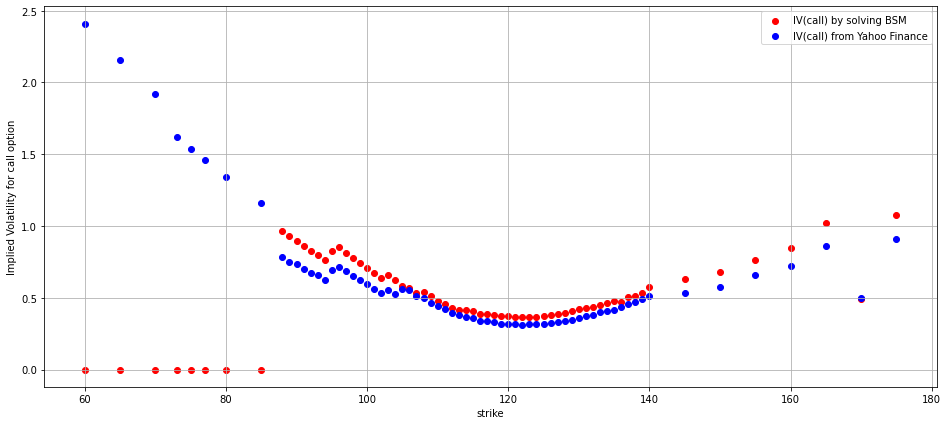

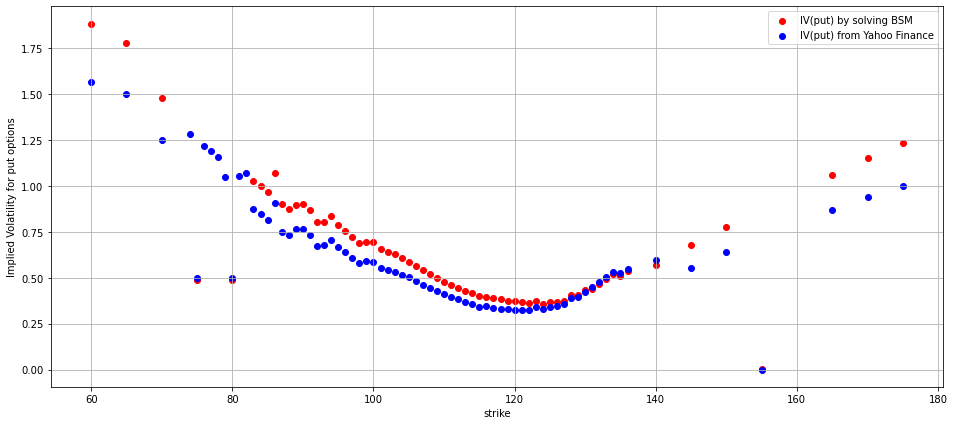

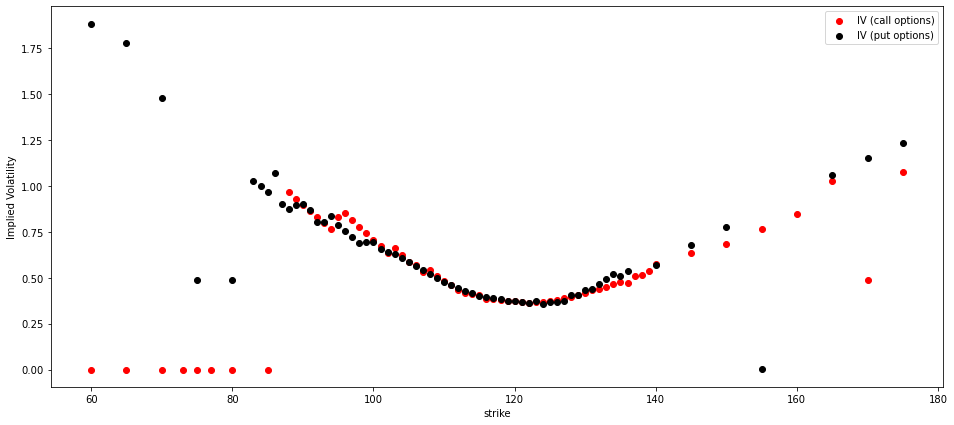

In [31]:
# plot
k_call, IV_call = IV_plot(DF_calls, 'c', s, 8)
k_put,  IV_put  = IV_plot(DF_puts,  'p', s, 8)

plt.figure(figsize=(16, 7))
e = plt.scatter(k_call, IV_call, c='red',   label="IV(call options)")
f = plt.scatter(k_put,  IV_put,  c='black', label="IV(put options)")
plt.xlabel('strike')
plt.ylabel('Implied Volatility')
plt.legend((e,f), ("IV (call options)", "IV (put options)"))

In [ ]:
do_quandl = False
if do_quandl:
    import quandl

    quandl.ApiConfig.api_key = 'NxTUTAQswbKs5ybBbwfK'
    goog_table = quandl.get('WIKI/GOOG')
    # use the daily data of Google(NASDAQ: GOOG) from 01/2016 to 08/2016
    close = goog_table['2016-01':'2016-08']['Adj. Close']
    r = diff(log(close))
    r_mean = mean(r)
    diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
    std = sqrt(sum(diff_square)*(1.0/(len(r)-1)))
    vol = std*sqrt(252)

    vol